In [1]:
#Import and set magics
import numpy as np
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader
import pydst
import statsmodels.api as stat
import statsmodels.formula.api as statf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy import interpolate
from scipy import linalg
import sympy as sm
import math
import random

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D



# Estimating income processes


Consider $N$ households indexed by $i$ who are in the labor market for $T$ periods indexed by $t \in ${1,2,...,T}$,

Their **wage income** is stochastic and given by,
 
$P_{i,t}$ = $\psi_{i,t}$ $P_{i,t-1}$

$\tilde{Y}_{i,t}$ = $xi_{i,t}$ $P_{i,t}$

$Y_{i,t}$ = \left\begin{array}{rcl}$
            \overline{\overline{0}+\text{if}\mu_{i,t}<\pi}
            \\tilde{Y}_{i,t} +\text{else}
            \end{array}\right.


   


$\psi_{i,t}$ ~ LogNormal(-0.5$\sigma_{\psi}^2$,$\sigma_{\psi})$

$\xi_{i,t}$ ~ LogNormal(-0.5$\sigma_{\xi}^2$,$\sigma_{\xi})$

$\mu_{i,t}$ ~ $Uniform(0,1)$


$P_{0} = 1$
   
where

$\sigma_{\psi}$ is the standard deviation of the *permanent* shocks, $\psi_{i,t}$

$\sigma_{\xi}$ is the standard deviation of the *transitory* shocks, $\xi_{i,t}$

$\pi$ is the risk of unemployment

The data you have access to is:


In [2]:
import numpy as np
dataY = np.load(r'C:\Users\musse\Documents\GitHub\projects-2020-zjr-hrv\projects-2020-zjr-hrv\dataY.npy')
T,N = dataY.shape
print(dataY)
print(dataY.shape)




[[0.83317569 0.72881172 0.         ... 1.16771806 0.93207083 0.86711803]
 [1.18542294 0.92826337 1.62913142 ... 1.13903869 0.94479246 0.78842682]
 [1.14813596 0.90542496 0.70634401 ... 1.49584791 1.08969956 0.        ]
 ...
 [0.73818651 0.59958039 0.56135238 ... 2.60075173 1.07070489 0.43010036]
 [1.14130879 0.85728537 0.54530761 ... 3.79294856 0.67764143 0.38720822]
 [0.64908127 0.85101393 0.59517395 ... 3.32800991 0.82400879 0.5814573 ]]
(20, 50000)


**Question 1:** Calculate income growth rates as log-changes

In [102]:
#Defining income growth rate by finding the first differences. Thereafter replacing the negative Y-values with .nan

logY = np.diff(np.log(dataY))
#diff_dataY = np.diff(dataY) 
  
# printing initial arrays 
print("Initial diff", logY) 
  
# code to replace all negative value with 0 
logY[logY<=0] = np.nan
  
# printing result 
print("New resulting diff: ", logY) 






initial diff [[-0.13382911        -inf         inf ...  0.45991757 -0.22539794
  -0.0722337 ]
 [-0.2445394   0.56248678 -0.45247293 ...  0.10650339 -0.18697465
  -0.18092569]
 [-0.2374906  -0.24830202  0.49367077 ...  0.38133059 -0.31679118
         -inf]
 ...
 [-0.20796646 -0.06588123  0.6550227  ...  1.08826931 -0.88748332
  -0.9120539 ]
 [-0.2861601  -0.45242079  0.43603115 ...  1.35354726 -1.7222807
  -0.5596557 ]
 [ 0.27087056 -0.35757477  0.31896575 ...  1.52939372 -1.39594858
  -0.34864367]]
New resulting diff:  [[       nan        nan        inf ... 0.45991757        nan        nan]
 [       nan 0.56248678        nan ... 0.10650339        nan        nan]
 [       nan        nan 0.49367077 ... 0.38133059        nan        nan]
 ...
 [       nan        nan 0.6550227  ... 1.08826931        nan        nan]
 [       nan        nan 0.43603115 ... 1.35354726        nan        nan]
 [0.27087056        nan 0.31896575 ... 1.52939372        nan        nan]]


**Question 2:** Calculate the following 3 statistics from the data:

$s_{1}$: Share of observations with $Y_{i,t}$=0

$s_{2}$: Variance of income growth rate, Var($\Delta$ Log $Y_{i,t}$)

$s_{3}$: Covariance of income growth rates one period apart, Cov($\Delta$ Log $Y_{i,t}$,$\Delta$ Log $Y_{i,t-1}$ )

To count shares of observations with $Y_{i,t}$=0, we use the nonzero-function

In [358]:
#S1:
print('Number of observations with Y=0 is') 
np.count_nonzero(dataY==0)



Number of observations with Y=0 is


49925

The variance is calculated by the mean of square minus the square of the mean, i.e.

$Var(x)=E[(X-\mu)^{2}]$



In [104]:
#S2:
print(np.var(logY))

nan


As seen above, the variance results in "nan", meaning we would have to remove the nan values from our sample to find a value for the variance. Hence, we find:

In [175]:
diffY = diff_dataY[~np.isnan(diff_dataY)]
print('The variance is' ,np.var(diffY))

The variance is 0.15780801990005514


Finally, the Covariance is found by $cov(X,Y)$ = $E[(X-E[X])(Y-E[Y])]$

In [689]:
diffY

array([0.94718895, 0.08465306, 0.20212118, ..., 1.94543748, 0.35063015,
       2.60694002])

In [688]:
np.cov(diffY)

array(0.15780833)

Question 3: Simulate the income process using your own choice of $\sigma_{\psi}$, $\sigma_{\xi}$, $\pi$, T and N. Calculate the 3 same statistics. Compare with the data statistics

In [3]:
# skal bruge i 1.2 og 1.3 

def momments(Y):
    s_sim1 = np.count_nonzero(Y==0)/np.size(Y)
    Y[Y<0] = np.nan
    Ydiff = np.diff(np.log(Y))
    cov = pd.DataFrame(Ydiff).cov()

    s_sim2 = np.zeros(Ydiff.shape[1])
    for i in range(Ydiff.shape[1]):
        s_sim2[i] = cov.iloc[i,i]
    s_sim2 = np.mean(s_sim2)

    s_sim3 = np.zeros(Ydiff.shape[1]-1)
    for i in range(Ydiff.shape[1]-1):
        s_sim3[i] = cov.iloc[i,(i+1)]
    s_sim3 = np.mean(s_sim3)

    return s_sim1, s_sim2, s_sim3

In [4]:
s_data = [None]*3
s_data[0], s_data[1], s_data[2] = momments(dataY.T)
s_data

[0.049925, 0.054993983413371354, -0.022504802437365256]

In [32]:

#Simulated figures
T = 50
N = 1000
pi = 0.3
s_psi = 0.23
s_xi = 0.4
P_0 = 1


def sim(s_psi,s_xi,pi,N,T):
    #Model
    Y = np.zeros((N,T))
    np.random.seed(1)
    for t in range(T):
        psi = np.random.lognormal(-0.5 * s_psi, s_psi, N)
        xi = np.random.lognormal(-0.5 * s_xi,s_xi, N)
        P = psi * P_0
        Y_tilde = xi * P
        mu = np.random.uniform(0,1,N)
        Y[(pi<mu),t] = Y_tilde[(pi<mu)]
    return Y

Y_sim = sim(s_psi,s_xi,pi,N,T)

s_sim = [None]*3
s_sim[0], s_sim[1], s_sim[2] = momments(Y_sim)
s_sim



[0.29988, 17.827012770658502, -8.922596424853145]

In [63]:
def objective(s):

    Y = sim(s[0],s[1],s[2],N,T)
    s_sim1, s_sim2, s_sim3 = momments(Y)
    #obj =  (s_sim1 - s_data1)**2 + (s_sim2 - s_data2)**2 + (s_sim3 - s_data3)**2 
    obj =   (s_sim1 - s_data[0])**2 + (s_sim2 - s_data[1])**2 + (s_sim3 - s_data[2])**2 
    return obj



x0 = np.ones(3)/100

#res = optimize.minimize(objective,x,method='L-BFGS-B', bounds=((0,None),(0,None),(0,1)),tol=1e-20)
res = optimize.minimize(objective,x0,method='L-BFGS-B',options={'eps':1e-4},bounds=((0,None),(0,None),(0,None),))
#objective(x)
res

      fun: 1.6144875720339336e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.25305304e-05,  6.20294454e-06, -2.49368487e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 16
   status: 0
  success: True
        x: array([0.11493023, 0.11775912, 0.04956846])

In [62]:

Y = sim(0.11499217,0.11770293,0.05,N,T)
s_sim1, s_sim2, s_sim3 = momments(Y)
s_sim1 -s_data[0] 


0.000455000000000004

In [17]:
Y = sim(1,1,0.3,N,T)
s_sim1, s_sim2, s_sim3 = momments(Y)
s_sim1

0.29988

In [312]:
#first differences and log on Y_tilde
logY_tilde = np.diff(np.log(Y_tilde))
 
  
# printing initial arrays 
print("New diff", Y_tilde) 


New diff [0.76490623 0.54775785 0.87866154 0.3186033  0.58003673 1.14538839
 1.06600189 0.43761411 0.33612469 0.93192906 0.32228203 0.77918641
 0.68135253 0.64898698 0.76127426 0.70063782 0.56319563 0.96014644
 1.06190535 0.62759354 0.55334932 0.4683173  0.99910588 1.72282662
 1.07217598 1.33696167 0.6540446  0.42089238 0.46188817 0.50845608
 0.67628466 0.4640271  0.45399858 1.31992146 0.38433886 0.38542381
 1.17109731 0.41406103 0.75620395 0.69813366 0.7435846  0.73852665
 0.53507918 0.94476785 1.28570108 0.94804939 0.78152821 0.49901244
 0.89038294 0.93138788 0.81283685 0.48546922 1.45273448 1.31423155
 1.04130304 0.75836007 0.37889511 0.43730584 0.66222366 0.55180226
 0.56460394 1.16062731 0.40278451 0.48118903 0.86071215 1.08291318
 0.37415956 0.69293963 0.50797687 0.69159815 0.53920818 0.41954049
 0.649402   0.48079952 0.53432434 0.73457489 0.43178342 0.42043118
 1.11767808 0.78761336 1.01611968 0.68959211 0.42375901 0.53289127
 0.98430296 0.54545086 0.9800488  0.95776761 0.548158

In [168]:
#Calculating s1_sim
print('Number of observations with Y=0 is') 
np.count_nonzero(logY_tilde==0)

Number of observations with Y=0 is


0

In [169]:
#Calculating s2_sim
print(np.var(logY_tilde))

0.44214824517553175


In [170]:
#Calculating s3_sim
np.cov(logY_tilde)

array(0.44259128)

Comparison of the simulated data and the factual dataset

s1_sim =0

s1_data = 49925

s2_sim = 0.44214824517553175

s2_data = 0.15780801990005514

s3_sim = 0.44259128

s3_data = 0.15780833423674454

**Question 4:** Solve the following minimization problem to estimate $\sigma_{\psi}$, $\sigma_{\xi}$ and $\pi$ 

$\sigma_{\psi}^*$, $\sigma_{\xi}^*$, $\pi^*$ = $arg_{\sigma_{\psi}>=0,\sigma_{\xi}>=0,\pi\in [0,1]}$               min $(s_{1}^{sim}-s_{1}^{data})^2$ + $(s_{2}^{sim}-s_{2}^{data})^2$ + $(s_{3}^{sim}-s_{3}^{data})^2$

where for each new guess of $\sigma_{\psi}$, $\sigma_{\xi}$ and $\pi$ you should be re-simulating the data with the same seed and re-calculate the 3 statistics

In [124]:
def objective(x):
 pass
res = optimize.minimize(objective,x,method='L-BFGS-B',bounds=(-3,3),args=(-3,3),options={'eps': 1e-4})


contour()

NameError: name 'x' is not defined

# Wealth in the utility function

In the final period, t=T, the household solves the following problem:



$$
\begin{aligned}
v_{T}(a_{T-1})&= \max_{c_{T}}\frac{(c_{T}^{1-\rho})}{1-\rho} + \kappa \frac{(a_{T}+a\underline)^{1-\sigma}}{1-\sigma} \\
\text{s.t.} \\
a_{T} = (1+r)a_{T-1}+y-c_{T}
\end{aligned}
$$

where 

 * $a_t$ is end-of-period assets in period $t$
 * $c_t$ is consumption in period $t$
 * $\rho$ is the CRRA-coefficient for consumption utility
 * $\sigma$ is the CRRA-coefficient for wealth utility
 * $\underline{a}$ is an *additive* scaling factor for wealth utility
 * $\kappa$ is a *multiplicative* scaling factor for wealth utility
 * $r$ is the rate of return
 * $y$ is income
  
The optimal **consumption function** is denoted $c_t^{*}(a_{t-1})$

The optimal **savings function** is denoted $a_t^{*}(a_{t-1}) = (1+r)a_{t-1} + y - c_t^{*}(a_{t-1})$.
  

In [418]:
# a. parameters
rho = 2.0
sigma = 1.2
kappa = 0.6
a_ubar = 2.0
r = 0.04
y = 1.0
# b. grids
a_lag_vec = np.linspace(0,300,300)



**Question 1:** Find and plot the functions $v_{T}(a_{T-1})$, $c_T^{*}(a_{T-1})$, and $a_T^{*}(a_{T-1})$
 

In [610]:
def utility (c,y,r,rho,kappa,a_lag,a_ubar,sigma):
    return c**(1-rho)/(1-rho) + (kappa*(((1+r)*a_lag+y-c)+a_ubar)**(1-sigma))/(1-sigma)


In [611]:
def solve_period_T(rho,kappa,a_ubar,sigma,y):

    vT_grid = np.empty(a_lag_vec.size)
    cT_grid = np.empty(a_lag_vec.size) 
    aT_grid = np.empty(a_lag_vec.size) 

    for i, a_lag in enumerate(a_lag_vec): 

    
        obj = lambda c: -utility(c,y,r,rho,kappa,a_lag_vec[i],a_ubar,sigma)
        x0 = a_lag_vec[i]/10 + y
        result = optimize.minimize(obj,[x0],method='L-BFGS-B')
        vT_grid[i] = -result.fun
        cT_grid[i] = result.x
        aT_grid[i] = (1+r)*a_lag_vec[i]+y-cT_grid[i]

    return vT_grid,cT_grid,aT_grid


In [612]:
beta = 0.97
T= 20

In [613]:
v_grid =  [None]*(T+1)
c_grid = [None]*(T+1)
a_grid = [None]*(T+1)
v_interp_list =  [None]*(T+1)

In [614]:
v_grid[T],c_grid[T],a_grid[T] = solve_period_T(rho,kappa,a_ubar,sigma,y)


In [629]:
v_interp_list[T] = interpolate.RegularGridInterpolator([a_lag_vec],v_grid[T], bounds_error=False)

In [636]:
def solve_period_t(rho,kappa,a_ubar,sigma,y,t):

    vt_grid = np.empty(a_lag_vec.size)
    ct_grid = np.empty(a_lag_vec.size) 
    at_grid = np.empty(a_lag_vec.size) 

    for i, a_lag in enumerate(a_lag_vec): 

    
        obj = lambda c: -utility(c,y,r,rho,kappa,a_lag_vec[i],a_ubar,sigma) - beta*v_interp_list[t+1]([((1+r)*a_lag+y-c)])
        x0 = a_lag_vec[i]/10 + y
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,None),))
        vt_grid[i] = -result.fun
        ct_grid[i] = result.x
        at_grid[i] = (1+r)*a_lag_vec[i]+y-ct_grid[i]

    return vt_grid,ct_grid,at_grid

In [641]:
for i in range(T):
    
    t = T-i-1
    v_gridt,c_gridt,a_gridt = solve_period_t(rho,kappa,a_ubar,sigma,y,t)
    v_grid[t] = v_gridt
    c_grid[t] = c_gridt
    a_grid[t] = a_gridt
    v_interp_list[t] = interpolate.RegularGridInterpolator([a_lag_vec],v_grid[t], bounds_error=False, fill_value=None)


In [644]:
s_0 = (r*a_lag_vec + y - c_grid[0])/(y+r*a_lag_vec)

(-10, 0)

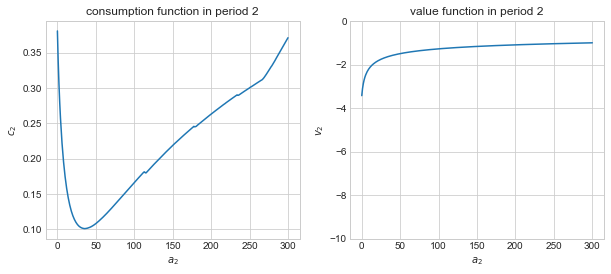

In [647]:


# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(a_lag_vec,s_0)
ax.set_xlabel('$a_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(a_lag_vec,vT_grid)
ax.set_xlabel('$a_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')
ax.set_ylim([-10,0])


In all periods *before the last*, $t < T$, the household solves:
 
 

$v_{t}(a_{t-1})$ = $max_{c_{t}} \frac{c_t^{1-\rho}}{1-\rho} + \kappa \frac{(a_t+\underline{a})^{1-\sigma}}{1-\sigma} + \beta v_{t+1}(a_t)$

{s.t.} 
    $a_{t} = (1+r)a_{t-1} + y - c_{t}$

where $\beta$ is the discount factor for future utility.

**Question 2:** Find and plot $v_{T-1}(a_{T-2})$ and  $c_{T-1}^{*}(a_{T-2})$.


In [283]:
beta = 0.97
T = 20


In [290]:
# grids
m1_vec = np.linspace(1e-8,10,100)
a2_vec = np.linspace(1e-8,10,100)


def solve_period_1(rho,beta,r,y,v2_interp, kappa):

    # a. grids
    a_lag_vec = np.linspace(0,300,300)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,a1 in enumerate(a1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],a1,rho,beta,r,y,v2_interp,kappa)
        
        # ii. initial guess (consume half)
        x0 = a1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,a1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return a1_vec,v1_vec,c1_vec

# solve
a1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,y,v2_interp,kappa)

# illustrate
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(a1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(a1_vec,v1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$')
ax.set_title('value function in period 1')
ax.set_ylim([-40,1])


TypeError: unsupported operand type(s) for +: 'float' and 'RegularGridInterpolator'

**Question 3:** Find $c_t^{*}(a_{t-1})$ for $t \in {0,1,...,T}$ and plot them in a single figure.


 


In [291]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for beta in [0.05,0.15,0.25]:
    a1_vec,c1_vec,a2_vec,c2_vec = solve(rho,beta,r,Delta,kappa)
    ax.plot(a1_vec,c1_vec,label=f'$\Delta = {Delta}$')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5])

TypeError: solve() missing 1 required positional argument: 'kappa'

Define the saving rate as:

$s_{t}^* (a_{t-1})$ = $\frac{(a_{t}-a_{t-1}+y-c_{t}^*(a_{t-1}))-a_{t-1}}{y+ra_{t-1}}$


**Question 4:** Plot $s_0^{*}(a_{-1})$. Do the rich or the poor save the most?
   

In [250]:
Delta = 0.5
a1_vec,c1_vec,a2_vec,c2_vec = solve(rho,beta,r,Delta,sigma,kappa)

c1_interp = interpolate.RegularGridInterpolator([a1_vec], c1_vec,
                                                bounds_error=False,fill_value=None)

c2_interp = interpolate.RegularGridInterpolator([a2_vec], c2_vec,
                                                bounds_error=False,fill_value=None)

#Draw initial distribution
# a. draw initial
simN = 10000
sim_a1 = np.fmax(np.random.normal(1,0.1,size=simN),0) # "randomly" chosen distribution

# b. period 1
sim_c1 = c1_interp(sim_a1)
sim_a1 = sim_a1-sim_c1

# c. transition to period 2 with random draw
sim_a2 = (1+r)*sim_a1+np.random.choice([0.5,1.5],p=[0.5,0.5])

# d. period 2
sim_c2 = c2_interp(sim_a2)

#Plot distributions
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(sim_c1,bins=100,label='period 1')
ax.hist(sim_c2,bins=100,label='period 2')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_t$')
ax.set_ylabel('freq.')
ax.set_title('consumption')

TypeError: unsupported operand type(s) for *: 'function' and 'float'

**Question 5:** Can you change the parameter choices such that $s_0^{*}(a_{-1})$ is monotonically decreasing in $a_{-1}$?

# Refined grid search

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `grid_search()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a grid size $N$ and minimum and maximum values of $x_{1}$ and $x_{2}$ denoted $\overline{x_{1}}$>$\underline{x_{1}}$ and $\overline{x_{2}}$>$\underline{x_{2}}$
2. Calculate step sizes 

    $\Delta_{1}$ =($\overline{x_{1}}$-$\underline{x_{1}}$)/(N-1)
    
    $\Delta_{2}$ =($\overline{x_{2}}$-$\underline{x_{2}}$)/(N-1)
3. Find the grid point with the lowest function value solving 

    $j^{*}_{1}$, $j^{*}_{2}$ = $arg_{j_{1}\in{0,...,N-1}, j_{2}\in{0,...,N-1}}$  f( $\underline{x_{1}+j_{1}$\Delta_{1}$,$\underline{x_{2}+j_{2}$\Delta_{2}$)

    
    


1. Return 


**Question 1:** Implement the grid_search() algorithm to minimize the rosen function.


In [648]:
def rosen(x):
 return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2


In [665]:
# settings
x1_min = 0
x1_max = 5
x2_min = 0
x2_max = 4
N = 1000
#Implementing grid_search()
def grid_search(f,x1_min,x1_max,x2_min,x2_max,N):
    
    #calculate step sizes
    delta1=(x1_max-x1_min)/(N-1)
    delta2=(x2_max-x2_min)/(N-1)

    f_min = np.inf
    arg_x_min = None
    x = None


    for i in range(N):
        for j in range(N):
            x = [x1_min+i*delta1,x2_min+j*delta2]
            f_val = f(x)
            if f_val < f_min:
                f_min = f_val
                arg_x_min = x
    



    return arg_x_min,f_min

# apply grid search
x,f = grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N)


**Question 2:** Implement the refined_grid_search() algorithm to minimize the rosen function

In [687]:
K = 10
def refined_grid_search(f,x1_min,x1_max,x2_min,x2_max,N,K):
    x = [None]*2
    k = 0
    for i in range(K):
        if k > 0:
            x1_delta = 3*(x1_max-x1_min)/(N-1)
            x2_delta = 3*(x2_max-x2_min)/(N-1)
            x1_min = np.maximum(x1_min,x[0]-x1_delta)
            x2_min = np.maximum(x2_min,x[1]-x2_delta)

            x1_max = np.minimum(x1_max,x[0]+x1_delta)
            x2_max = np.minimum(x2_max,x[1]+x2_delta)

        x,f_max = grid_search(f,x1_min,x1_max,x2_min,x2_max,N)
        k = k + 1
        if k >= K: 
            
            return x, f_max 


# more settings

# apply refined grid search
x,f_max = refined_grid_search(rosen,x1_min,x1_max,x2_min,x2_max,N,K)

In [685]:
np.minimum(1,2)

1